# Fit LN model by starting with matched two-exponential NA fit, then slightly adjusting to better capture offset responses

Note: must be run after NA fit

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize, signal, stats
import sys

from aux import load_npy
from disp import set_plot
from record_0_main import smlt_lnma

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

DUR_H = 10
IDUR_H = int(round(DUR_H/DT))

NNRN = 224
ALPHA = 0

FMA = 'data/simple/neur/baker_ma.npy'
FSAVE = 'data/simple/neur/baker_lnma_tweaked_4.npy'

In [2]:
# load data
DF_S = pd.read_csv('data/simple/neur/baker_resampled_s.csv')
DF_P = pd.read_csv('data/simple/neur/baker_resampled_p.csv')

I_S = np.array(DF_S['S'])
I_P = np.array(DF_P['P'])

R_SS = np.array(DF_S[[f'R_{cnrn}' for cnrn in range(NNRN)]])
R_PS = np.array(DF_P[[f'R_{cnrn}' for cnrn in range(NNRN)]])

T = np.arange(len(I_S))*DT

In [3]:
nrns_fit = np.arange(NNRN)
# nrns_fit = [64, 65, 66, 74, 78, 79, 85, 141, 142, 143, 144, 145, 176, 177, 180, 204, 205, 206, 207, 208]
# nrns_fit = [64, 65]

Load MA params

In [5]:
params_ma = load_npy(FMA)
tau_rs_ma = params_ma['TAU_R']
tau_as_ma = params_ma['TAU_A']
x_ss_ma = params_ma['X_S']
x_ps_ma = params_ma['X_P']

x_s_0_0s = np.nan*np.zeros(NNRN)
tau_s_0_0s = np.nan*np.zeros(NNRN)
x_s_1_0s = np.nan*np.zeros(NNRN)
tau_s_1_0s = np.nan*np.zeros(NNRN)

x_p_0_0s = np.nan*np.zeros(NNRN)
tau_p_0_0s = np.nan*np.zeros(NNRN)
x_p_1_0s = np.nan*np.zeros(NNRN)
tau_p_1_0s = np.nan*np.zeros(NNRN)

sgn_0s = np.zeros(NNRN)

for cnrn, (tau_r, tau_a, x_s, x_p) in enumerate(zip(tau_rs_ma, tau_as_ma, x_ss_ma, x_ps_ma)):
    gam = (1/tau_a) - (1/tau_r)
    
    x_s_0 = (x_s/(tau_r/tau_a - 1))*(-1/tau_r)
    tau_s_0 = tau_r
    x_s_1 = (x_s/(tau_r/tau_a - 1))*(1/tau_a)
    tau_s_1 = tau_a

    x_p_0 = (x_p/(tau_r/tau_a - 1))*(-1/tau_r)
    tau_p_0 = tau_r
    x_p_1 = (x_p/(tau_r/tau_a - 1))*(1/tau_a)
    tau_p_1 = tau_a
        
    # store derived two-exp params
    x_s_0_0s[cnrn] = x_s_0
    tau_s_0_0s[cnrn] = tau_s_0
    x_s_1_0s[cnrn] = x_s_1
    tau_s_1_0s[cnrn] = tau_s_1
    
    x_p_0_0s[cnrn] = x_p_0
    tau_p_0_0s[cnrn] = tau_p_0
    x_p_1_0s[cnrn] = x_p_1
    tau_p_1_0s[cnrn] = tau_p_1
    
    sgn_0s[cnrn] = np.sign(np.mean([x_s, x_p]))
    
params_0 = {
    'TAU_R': tau_rs_ma, 'TAU_A': tau_as_ma, 'X_S': x_ss_ma, 'X_P': x_ps_ma
}

# Examine pre-fit responses

In [6]:
r_smln_s_0s = smlt_lnma(I_S, 0*I_P, params_0, DT)
r_smln_p_0s = smlt_lnma(0*I_S, I_P, params_0, DT)

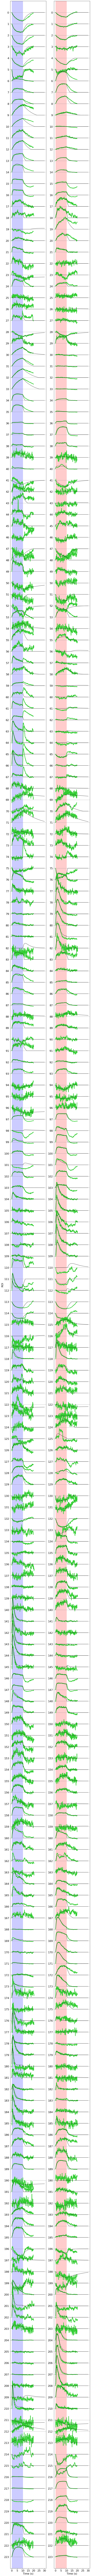

In [7]:
nplot = len(nrns_fit)
t = np.arange(len(R_SS))*DT

fig, axs = plt.subplots(1, 2, figsize=(8, nplot), tight_layout=True)
y_ticks = []

for cnrn, inrn in enumerate(nrns_fit):
    y_tick = -4*cnrn
    
    ## sine response
    axs[0].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[0].plot(t, R_SS[:, inrn] + y_tick, c='limegreen', lw=3)  # true
    axs[0].plot(t, r_smln_s_0s[:, inrn] + y_tick, c='k', lw=1)  # simulated 
    
    ## pulse response
    axs[1].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[1].plot(t, R_PS[:, inrn] + y_tick, c='limegreen', lw=3)
    axs[1].plot(t, r_smln_p_0s[:, inrn] + y_tick, c='k', lw=1)  # simulated
    
    y_ticks.append(y_tick)
    
axs[0].axvspan(0, 10, color='b', alpha=.2)
axs[1].axvspan(0, 10, color='r', alpha=.2)

axs[0].set_ylabel('ROI')

for ax in axs:
    set_plot(ax, y_lim=(-4*nplot, 4), y_ticks=y_ticks, y_tick_labels=nrns_fit, x_label='Time (s)', font_size=16)

# Adjust timescales, etc

In [8]:
# set of neurons to ignore sine-offset response in fitting
ignore_off_s = [57, 60, 61, 62, 63, 64, 65, 66, 67, 74, 98, 101, 110, 146, 147, 162]
ignore_off_p = [62, 65, 67, 74, 98, 146, 147]

In [9]:
# objective function for ln2e fit
def obj(param, r_s, r_p, sgn):
    tau_r, tau_a, x_s, x_p = param
    
    params_temp = {
        'TAU_R': np.array([tau_r]),
        'TAU_A': np.array([tau_a]),
        'X_S': np.array([x_s]),
        'X_P': np.array([x_p]),
    }
    
    r_smln_s = smlt_lnma(I_S, 0*I_P, params_temp, DT)[:, 0]
    r_smln_p = smlt_lnma(0*I_S, I_P, params_temp, DT)[:, 0]
    
    # compute error
    mse = np.nanmean(cc([r_s-r_smln_s, r_p-r_smln_p])**2)
    return mse

bounds = [(.001, 120), (.001, 120), (-100, 100), (-100, 100)]

In [10]:
# loop over nrns
# x_s_0_1s = np.nan*np.zeros(NNRN)
# tau_s_0_1s = np.nan*np.zeros(NNRN)
# x_s_1_1s = np.nan*np.zeros(NNRN)
# tau_s_1_1s = np.nan*np.zeros(NNRN)

# x_p_0_1s = np.nan*np.zeros(NNRN)
# tau_p_0_1s = np.nan*np.zeros(NNRN)
# x_p_1_1s = np.nan*np.zeros(NNRN)
# tau_p_1_1s = np.nan*np.zeros(NNRN)
tau_rs = np.nan*np.zeros(NNRN)
tau_as = np.nan*np.zeros(NNRN)
x_ss = np.nan*np.zeros(NNRN)
x_ps = np.nan*np.zeros(NNRN)


for cnrn, inrn in enumerate(nrns_fit):
    sys.stdout.write('.')
    r_s = R_SS[:, inrn].copy()
    r_p = R_PS[:, inrn].copy()
    
    if inrn in ignore_off_s:
        r_s[T >= 10] = np.nan
    if inrn in ignore_off_p:
        r_p[T >= 10] = np.nan
        
    x_0 = [
        tau_rs_ma[inrn], tau_as_ma[inrn], x_ss_ma[inrn], x_ps_ma[inrn]
    ]
    
    # fit model
    np.random.seed(0)
    fit_rslt = optimize.minimize(obj, x_0, args=(r_s, r_p, sgn_0s[inrn]), bounds=bounds)
    
    # unpack params
    tau_r, tau_a, x_s, x_p = fit_rslt.x
    
    print(f'Nrn {inrn}', tau_r, tau_a, x_s, x_p)
 
    tau_rs[inrn] = tau_r
    tau_as[inrn] = tau_a
    x_ss[inrn] = x_s
    x_ps[inrn] = x_p

.Nrn 0 11.408642439281243 22.414279916875056 -7.191384961740552 -3.6369414754738765
.Nrn 1 4.033407821495651 120.0 -3.645482065724114 -1.2536376265145222
.Nrn 2 5.396814672026581 120.0 -4.314044600603289 -1.9789047065922492
.Nrn 3 4.706424791962787 120.0 -3.239243155352643 -1.0975745091694542
.Nrn 4 7.126500630445765 120.0 -4.568670247423972 -3.294085469111358
.Nrn 5 0.7933481541235774 37.71226383730196 -3.1290305296948073 -0.7585565557068048
.Nrn 6 4.318026469566333 120.0 0.8637898535933575 4.1865966288919765
.Nrn 7 3.416986471293894 120.0 1.5562925344166507 3.626702558273842
.Nrn 8 4.343701711572418 120.0 2.104580810275515 3.3192597717685635
.Nrn 9 38.49625085568876 41.27559718393004 19.52705193933491 4.881090869682735
.Nrn 10 35.721281732613456 36.56377583260552 14.38653865174054 -0.3895006488343455
.Nrn 11 5.88122762680946 65.13011845076201 3.84437389362957 0.7925828710073081
.Nrn 12 7.489987609486325 120.0 4.708910775214226 1.171309648607774
.Nrn 13 2.845725527699816 120.0 2.92644

In [13]:
params_1 = {
    'EXPT_ID': np.arange(NNRN),
    'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps
}

# Examine Step-1 responses

In [14]:
r_smln_s_1s = smlt_lnma(I_S, 0*I_P, params_1, DT)
r_smln_p_1s = smlt_lnma(0*I_S, I_P, params_1, DT)

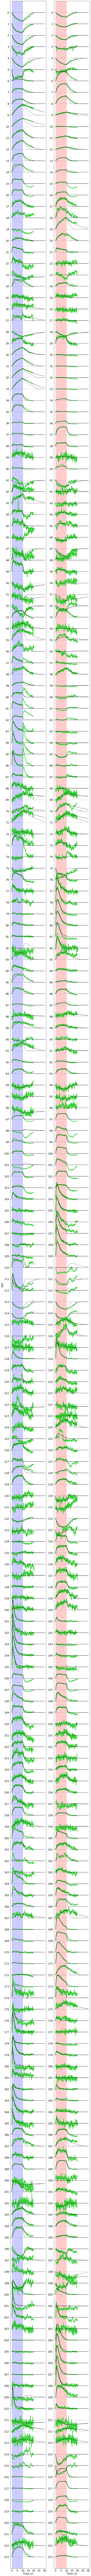

In [15]:
nplot = len(nrns_fit)
t = np.arange(len(R_SS))*DT

fig, axs = plt.subplots(1, 2, figsize=(8, nplot), tight_layout=True)
y_ticks = []

for cnrn, inrn in enumerate(nrns_fit):
    y_tick = -4*cnrn
    
    ## sine response
    axs[0].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[0].plot(t, R_SS[:, inrn] + y_tick, c='limegreen', lw=3)  # true
    axs[0].plot(t, r_smln_s_0s[:, inrn] + y_tick, c='k', lw=1, ls='--')  # simulated 
    axs[0].plot(t, r_smln_s_1s[:, inrn] + y_tick, c='k', lw=1)  # simulated 
    
    ## pulse response
    axs[1].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[1].plot(t, R_PS[:, inrn] + y_tick, c='limegreen', lw=3)
    axs[1].plot(t, r_smln_p_0s[:, inrn] + y_tick, c='k', lw=1, ls='--')  # simulated
    axs[1].plot(t, r_smln_p_1s[:, inrn] + y_tick, c='k', lw=1)  # simulated
    
    y_ticks.append(y_tick)
    
axs[0].axvspan(0, 10, color='b', alpha=.2)
axs[1].axvspan(0, 10, color='r', alpha=.2)

axs[0].set_ylabel('ROI')

for ax in axs:
    set_plot(ax, y_lim=(-4*nplot, 4), y_ticks=y_ticks, y_tick_labels=nrns_fit, x_label='Time (s)', font_size=16)

In [16]:
np.save(FSAVE, np.array([params_1]))

In [17]:
params_1

{'EXPT_ID': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 17